<a href="https://colab.research.google.com/github/cicorias/njit-deeplearn-explain-shap/blob/master/shap-final-run.ipynb" target=_parent>
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Overview
## Setup notebook python imports

In [21]:
import pkgutil
if pkgutil.find_loader('shap'):
    print('shap installed.. ')
else:
    print('you must install shap via pip')

shap installed.. 


In [ ]:
## Uncomment and run ONLY if you have not install shap before ..
#!pip install shap

In [1]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import shap

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


## Utility methods

### Download model files
This will download large h5 model files needed for this notebook from Azure blob storage.

### Remove text
this is the same logic from intial model training for removing text during preprocessing on x-ray images.

In [2]:

def download_files(links):
    import os.path
    import urllib.request
    from IPython.display import clear_output
    
    class MyProgressBar():
        def __init__(self, filename):
            self.filename = filename
            self.bar_length = 20
            self.last_block = 0
            
        def __call__(self, count, block_size, total_size):
            progress = (count * block_size) / total_size
            block = int(round(self.bar_length * progress))
            
            if block < self.last_block:
                self.last_block = block
                
            if (block != self.last_block):
                self.last_block = block
                clear_output(wait = True)
                text = "File: {0} - Progress: [{1}] {2:.1f}%".format(self.filename, "#" * block + "-" * (self.bar_length - block), progress * 100)
                print(text)

    
    download_folder = './downloads'
    os.makedirs(download_folder, exist_ok=True) 
    for link in links:
        link = link.strip()
        name = link.rsplit('/', 1)[-1]
        filename = os.path.join(download_folder, name)

        if not os.path.isfile(filename):
            print('Downloading: ' + filename)
            try:
                urllib.request.urlretrieve(link, filename, MyProgressBar(filename)) #  progress_report(filename))
            except Exception as inst:
                print(inst)
                print('  Encountered unknown error. Continuing.')
                
                
                
def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    import cv2
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result

## Setup
Here we setup a simple list of any models needed. We are only using the one model as described in our paper.

Subsequently we need to load weights explicityly.

In [15]:
models = ['https://scicoria.blob.core.windows.net/public/model20201115-151427-random-imbalance-NO-fiscore-resnet50v2.h5']

download_files(models)

model = load_model('./downloads/model20201115-151427-random-imbalance-NO-fiscore-resnet50v2.h5') 
model.load_weights('./downloads//model20201115-151427-random-imbalance-NO-fiscore-resnet50v2.h5')


images = ['https://scicoria.blob.core.windows.net/public/images/covid/COVID-00001.jpg',
          'https://scicoria.blob.core.windows.net/public/images/covid/COVID-00015a.png',
         'https://scicoria.blob.core.windows.net/public/images/covid/COVID-00015b.png',
        'https://scicoria.blob.core.windows.net/public/images/non-covid/COVID-00010.jpg',
         'https://scicoria.blob.core.windows.net/public/images/non-covid/COVID-00013a.jpg',
         'https://scicoria.blob.core.windows.net/public/images/non-covid/COVID-00013b.jpg']


download_files(images)


File: ./downloads\COVID-00010.jpg - Progress: [#####################] 104.0%


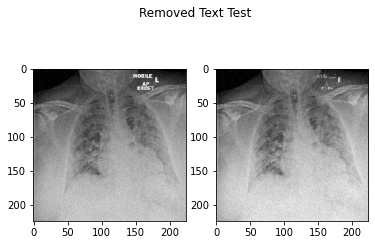

In [16]:
# just check our remove text

def show_example():
    img_width, img_height = 224, 224
    %matplotlib inline
    from matplotlib.pyplot import imshow
    import matplotlib.pyplot as plt

    fig,(ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Removed Text Test')
    raw_image = load_img('./downloads/COVID-00001.jpg', target_size = (img_width, img_height))
    cleaned_image =  array_to_img(remove_text( img_to_array(raw_image)))

    ax1.imshow(raw_image)
    ax2.imshow(cleaned_image)
    plt.show()
    
show_example()

In [5]:
# Need to load X-Ray Data

img_width, img_height = 224, 224

def get_image_array(image_names):
    rv = []
    for i in image_names:
        raw_image = img_to_array(load_img(path = i, target_size = (img_width, img_height)))        
        clean_image = remove_text(raw_image)
        rv.append(clean_image.reshape(1, img_width, img_height, 3))
        
    return np.vstack(rv)

# provides the mapping of the input images along with the input layer
# needed for GradientExplainer
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return tf.compat.v1.keras.backend.get_session().run(model.layers[layer].input, feed_dict)

def run_explainier(model, layer_to_use, to_explain):
    e = shap.GradientExplainer((model.layers[layer_to_use].input, model.layers[-1].output), map2layer(preprocess_input(to_explain.copy()), layer_to_use))
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer_to_use), ranked_outputs=1) 
    class_names = { 0:'COVID', 1: 'non-COVID'}
    fn =np.vectorize(lambda x: class_names[x])(indexes)
    return shap.image_plot(shap_values, to_explain, fn, show=False)
    
    
    

# Images used
>Note: For the images shown below, they are in the following order for each:

### COVID
1. COVID-00001.jpg
1. COVID-00015a.png
1. COVID-00015b.png
### non-COVID
1. COVID-00010.jpg
1. COVID-00013a.jpg
1. COVID-00013b.jpg


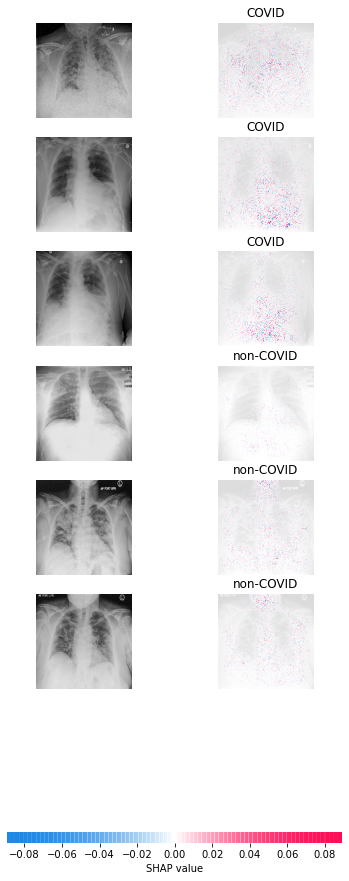

In [18]:

# THE FIRST THREE IMAGES ARE COVID POSTIVE; THE SECOND THREE IMAGES ARE NEGATIVE.

to_explain = get_image_array(["./downloads/COVID-00001.jpg", "./downloads/COVID-00015a.png", "./downloads/COVID-00015b.png",
                            "./downloads/COVID-00010.jpg", "./downloads/COVID-00013a.jpg", "./downloads/COVID-00013b.jpg"])


pp = run_explainier(model, 2, to_explain)

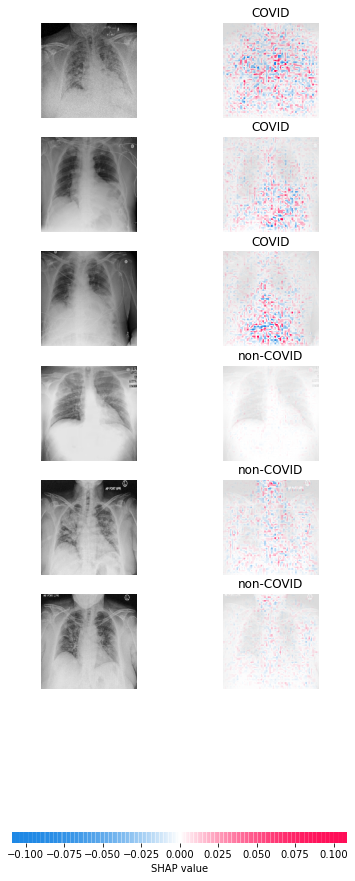

In [7]:
pp = run_explainier(model, 7, to_explain)

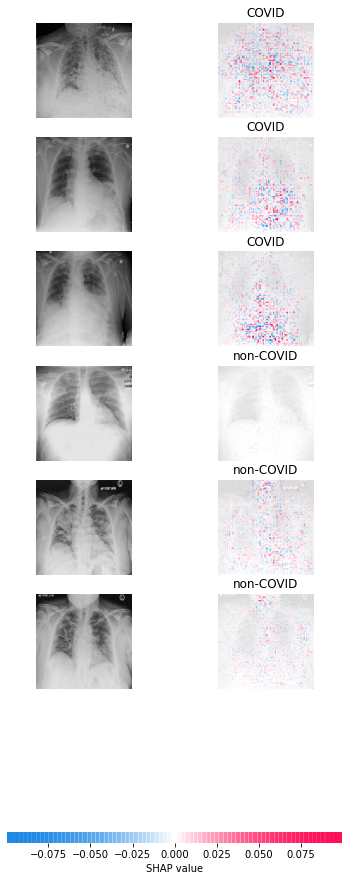

In [8]:
pp = run_explainier(model, 14, to_explain)